In [1]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import iqr, skew, kurtosis

# --- CONFIGURATION ---
hey_tvs_dir = "../DataSet/Audio_dataset/hey_tvs_2sec"
non_hey_tvs_dir = "../DataSet/Audio_dataset/non_hey_tvs_2sec"

In [2]:
# --- FEATURE EXTRACTION ---
def extract_features(filepath):
    y, sr = librosa.load(filepath, sr=None)
    duration = librosa.get_duration(y=y, sr=sr)
    rms = np.mean(librosa.feature.rms(y=y))
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=y))
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    mfcc_mean = np.mean(mfccs, axis=1)
    return {
        'duration': duration,
        'rms': rms,
        'zcr': zcr,
        **{f'mfcc_{i+1}': mfcc for i, mfcc in enumerate(mfcc_mean)}
    }

In [3]:
# --- LOAD DATA ---
data = []

# Hey TVS
for i in range(1, 201):
    path = os.path.join(hey_tvs_dir, f"{i}.wav")
    features = extract_features(path)
    features['label'] = 'hey_tvs'
    data.append(features)

# Non-Hey TVS
for i in range(201, 410):
    path = os.path.join(non_hey_tvs_dir, f"{i}.wav")
    features = extract_features(path)
    features['label'] = 'non_hey_tvs'
    data.append(features)

df = pd.DataFrame(data)

# Save features
df.to_csv("wake_word_features.csv", index=False)

In [4]:
# --- DESCRIPTIVE STATISTICS ---
def compute_extended_stats(df, features):
    result = {}
    for label in df['label'].unique():
        stats = {}
        subset = df[df['label'] == label]
        for feat in features:
            values = subset[feat]
            stats[feat] = {
                'mean': values.mean(),
                'median': values.median(),
                'std': values.std(),
                'min': values.min(),
                'max': values.max(),
                'range': values.max() - values.min(),
                'iqr': iqr(values),
                'skewness': skew(values),
                'kurtosis': kurtosis(values)
            }
        result[label] = pd.DataFrame(stats).T
    return result

features_to_analyze = ['duration', 'rms', 'zcr']
stats_dict = compute_extended_stats(df, features_to_analyze)

C:\Users\anirban.saha\AppData\Local\Temp\ipykernel_8056\1878575904.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(values),
C:\Users\anirban.saha\AppData\Local\Temp\ipykernel_8056\1878575904.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'kurtosis': kurtosis(values)
C:\Users\anirban.saha\AppData\Local\Temp\ipykernel_8056\1878575904.py:17: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  'skewness': skew(values),
C:\Users\anirban.saha\AppData\Local\Temp\ipykernel_8056\1878575904.py:18: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occ

In [5]:
# Combine stats into a multi-index DataFrame
combined_stats = pd.concat(stats_dict.values(), keys=stats_dict.keys())
print("\nDetailed Descriptive Statistics:\n")
print(combined_stats)


Detailed Descriptive Statistics:

                          mean    median           std       min       max  \
hey_tvs     duration  1.984000  1.984000  6.678054e-16  1.984000  1.984000   
            rms       0.019253  0.017319  1.070189e-02  0.001764  0.055146   
            zcr       0.163248  0.167316  2.707116e-02  0.084961  0.281519   
non_hey_tvs duration  2.000000  2.000000  0.000000e+00  2.000000  2.000000   
            rms       0.009426  0.008332  4.319912e-03  0.001947  0.025919   
            zcr       0.043729  0.041171  1.573224e-02  0.021030  0.122735   

                         range       iqr  skewness  kurtosis  
hey_tvs     duration  0.000000  0.000000       NaN       NaN  
            rms       0.053383  0.015155  0.752599 -0.030390  
            zcr       0.196558  0.040040 -0.006481  1.093293  
non_hey_tvs duration  0.000000  0.000000       NaN       NaN  
            rms       0.023972  0.004490  1.213057  1.347217  
            zcr       0.101705  0.014916

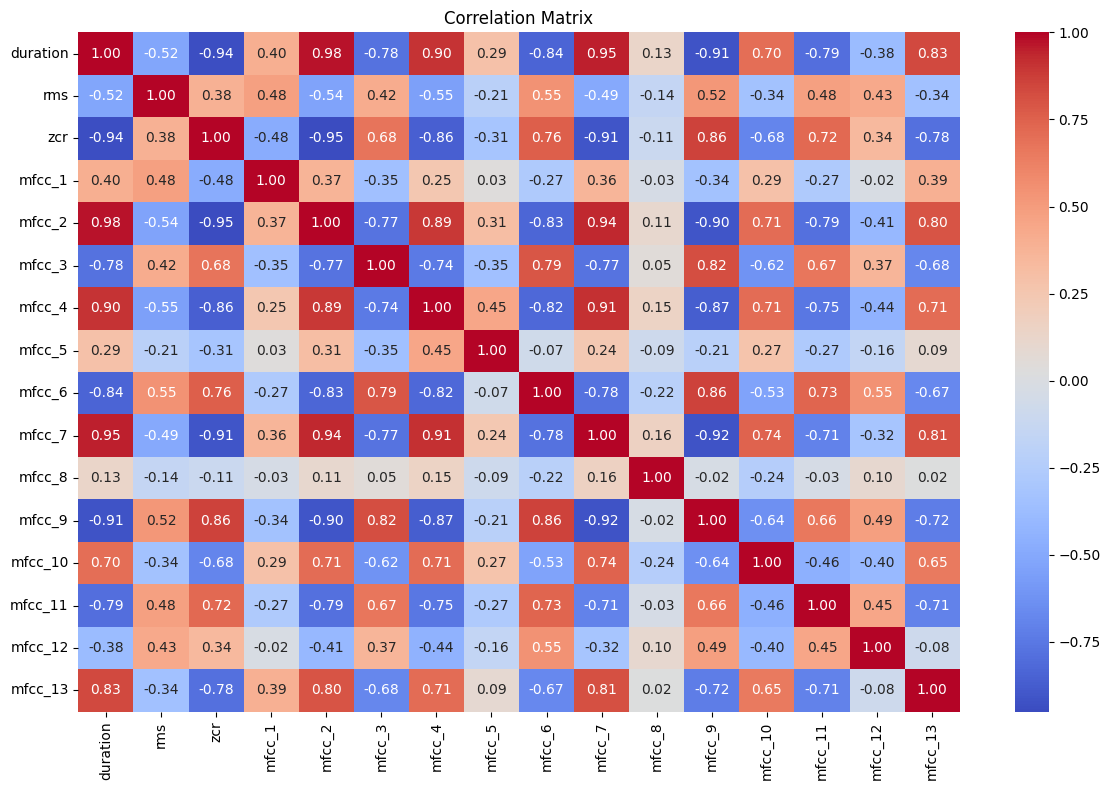

In [6]:
# --- CORRELATION HEATMAP ---
plt.figure(figsize=(12, 8))
corr = df[features_to_analyze + [f'mfcc_{i}' for i in range(1, 14)]].corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix")
plt.tight_layout()
plt.show()

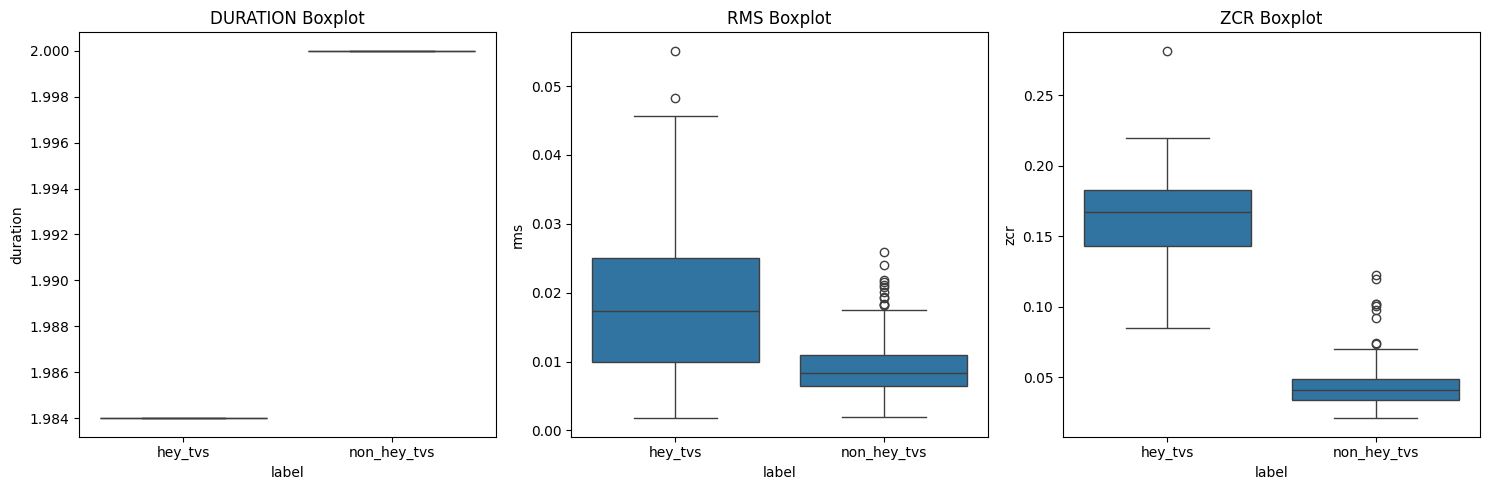

In [7]:
# --- BOX PLOTS ---
plt.figure(figsize=(15, 5))
for i, feat in enumerate(features_to_analyze):
    plt.subplot(1, 3, i+1)
    sns.boxplot(data=df, x='label', y=feat)
    plt.title(f"{feat.upper()} Boxplot")
plt.tight_layout()
plt.show()

C:\Users\anirban.saha\AppData\Local\Temp\ipykernel_8056\82206343.py:5: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=df, x=feat, hue='label', fill=True, alpha=0.5)


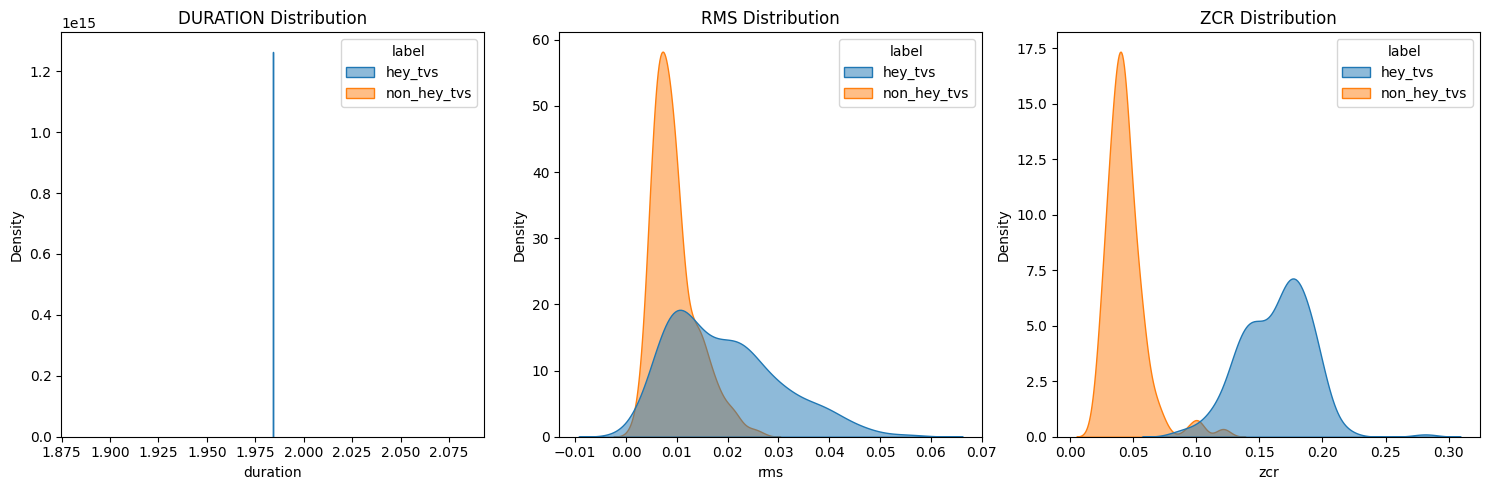

In [8]:
# --- KDE PLOTS ---
plt.figure(figsize=(15, 5))
for i, feat in enumerate(features_to_analyze):
    plt.subplot(1, 3, i+1)
    sns.kdeplot(data=df, x=feat, hue='label', fill=True, alpha=0.5)
    plt.title(f"{feat.upper()} Distribution")
plt.tight_layout()
plt.show()

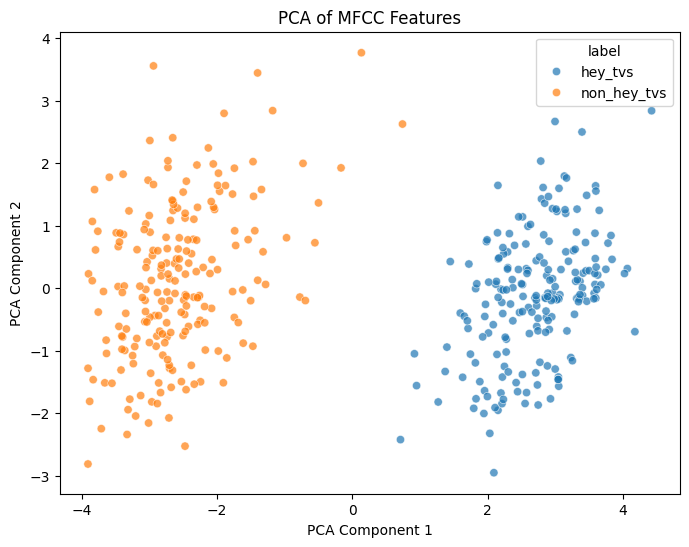

In [9]:
# PCA for MFCCs to visualize clustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

mfcc_cols = [col for col in df.columns if col.startswith("mfcc")]
X = df[mfcc_cols]
y = df['label']

# Standardize features
X_scaled = StandardScaler().fit_transform(X)

# PCA to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y, alpha=0.7)
plt.title('PCA of MFCC Features')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.show()